# TRYING OUT PINN

### Read the Obsidian vault named PINN_tryout for detailed info

In [1]:
from collections import OrderedDict
from typing import Callable

import torch
from torch import nn
from torch.func import functional_call, grad, vmap

import argparse
import matplotlib.pyplot as plt
import numpy as np
import torchopt

In [2]:
class LinearNN(nn.Module):
    def __init__(
        self,
        num_inputs: int = 1,
        num_layers: int = 1,
        num_neurons: int = 5,
        act: nn.Module = nn.Tanh(),
    ) -> None:
        """Basic neural network architecture with linear layers
        
        Args:
            num_inputs (int, optional): the dimensionality of the input tensor
            num_layers (int, optional): the number of hidden layers
            num_neurons (int, optional): the number of neurons for each hidden layer
            act (nn.Module, optional): the non-linear activation function to use for stitching
                linear layers togeter
        """
        super().__init__()
        
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []

        # input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons))

        # hidden layers with linear layer and activation
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])

        # output layer
        layers.append(nn.Linear(num_neurons, 1))

        # build the network
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1, 1)).squeeze()

In [3]:
def make_forward_fn(
    model: nn.Module,
    derivative_order: int = 1,
) -> list[Callable]:
    """Make a functional forward pass and gradient functions given an input model

    This function creates a set of functional calls of the input model

    It returns a list of composable v-mapped version of the forward pass
    and of higher-order derivatives with respect to the inputs as
    specified by the input argument `derivative_order`

    Args:
        model (nn.Module): the model to make the functional calls for. It can be any subclass of
            a nn.Module
        derivative_order (int, optional): Up to which order return functions for computing the
            derivative of the model with respect to the inputs

    Returns:
        list[Callable]: A list of functions where each element corresponds to
            a v-mapped version of the model forward pass and its derivatives. The
            0-th element is always the forward pass and, depending on the value of
            the `derivative_order` argument, the following elements corresponds to
            the i-th order derivative function with respect to the model inputs. The
            vmap ensures efficient support for batched inputs
    """
    # notice that `functional_call` supports batched input by default
    # thus there is not need to call vmap on it, as it's instead the case
    # for the derivative calls
    def f(x: torch.Tensor, params: dict[str, torch.nn.Parameter] | tuple[torch.nn.Parameter, ...]) -> torch.Tensor:
        
        # the functional optimizer works with parameters represented as a tuple instead
        # of the dictionary form required by the `functional_call` API 
        # here we perform the conversion from tuple to dictionary
        if isinstance(params, tuple):
            params_dict = tuple_to_dict_parameters(model, params)
        else:
            params_dict = params

        return functional_call(model, params_dict, (x, ))

    fns = []
    fns.append(f)

    dfunc = f
    for _ in range(derivative_order):

        # first compute the derivative function
        dfunc = grad(dfunc)

        # then use vmap to support batching
        dfunc_vmap = vmap(dfunc, in_dims=(0, None))

        fns.append(dfunc_vmap)

    return fns


In [4]:
def tuple_to_dict_parameters(
        model: nn.Module, params: tuple[torch.nn.Parameter, ...]
) -> OrderedDict[str, torch.nn.Parameter]:
    """Convert a set of parameters stored as a tuple into a dictionary form

    This conversion is required to be able to call the `functional_call` API which requires
    parameters in a dictionary form from the results of a functional optimization step which 
    returns the parameters as a tuple

    Args:
        model (nn.Module): the model to make the functional calls for. It can be any subclass of
            a nn.Module
        params (tuple[Parameter, ...]): the model parameters stored as a tuple
    
    Returns:
        An OrderedDict instance with the parameters stored as an ordered dictionary
    """
    keys = list(dict(model.named_parameters()).keys())
    values = list(params)
    return OrderedDict(({k:v for k,v in zip(keys, values)}))

In [5]:
model = LinearNN(num_layers=2)
fns = make_forward_fn(model, derivative_order=2)

batch_size = 10
x = torch.randn(batch_size)
# params = dict(model.named_parameters())
params = dict(model.named_parameters())

fn_x = fns[0](x, params)
assert fn_x.shape[0] == batch_size

dfn_x = fns[1](x, params)
assert dfn_x.shape[0] == batch_size

ddfn_x = fns[2](x, params)
assert ddfn_x.shape[0] == batch_size

In [6]:
R = 1.0  # rate of maximum population growth parameterizing the equation
X_BOUNDARY = 0.0  # boundary condition coordinate
F_BOUNDARY = 0.5  # boundary condition value


def make_loss_fn(f: Callable, dfdx: Callable) -> Callable:
    """Make a function loss evaluation function

    The loss is computed as sum of the interior MSE loss (the differential equation residual)
    and the MSE of the loss at the boundary

    Args:
        f (Callable): The functional forward pass of the model used a universal function approximator. This
            is a function with signature (x, params) where `x` is the input data and `params` the model
            parameters
        dfdx (Callable): The functional gradient calculation of the universal function approximator. This
            is a function with signature (x, params) where `x` is the input data and `params` the model
            parameters

    Returns:
        Callable: The loss function with signature (params, x) where `x` is the input data and `params` the model
            parameters. Notice that a simple call to `dloss = functorch.grad(loss_fn)` would give the gradient
            of the loss with respect to the model parameters needed by the optimizers
    """

    def loss_fn(params: torch.Tensor, x: torch.Tensor):

        # interior loss
        f_value = f(x, params)
        interior = dfdx(x, params) - R * f_value * (1 - f_value)

        # boundary loss
        x0 = X_BOUNDARY
        f0 = F_BOUNDARY
        x_boundary = torch.tensor([x0])
        f_boundary = torch.tensor([f0])
        boundary = f(x_boundary, params) - f_boundary

        loss = nn.MSELoss()
        loss_value = loss(interior, torch.zeros_like(interior)) + loss(
            boundary, torch.zeros_like(boundary)
        )

        return loss_value

    return loss_fn

In [8]:
# Configuration
num_hidden = 5
dim_hidden = 5
batch_size = 30
num_iter = 100
tolerance = 1e-8
learning_rate = 1e-1
domain = (-5.0, 5.0)

# Model initialization
model = LinearNN(num_layers=num_hidden, num_neurons=dim_hidden, num_inputs=1)
funcs = make_forward_fn(model, derivative_order=1)

f = funcs[0]
dfdx = funcs[1]
loss_fn = make_loss_fn(f, dfdx)

# Optimizer
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

# Training loop
params = tuple(model.parameters())
loss_evolution = []
for i in range(num_iter):
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])
    loss = loss_fn(params, x)
    params = optimizer.step(loss, params)
    print(f"Iteration {i} with loss {float(loss)}")
    loss_evolution.append(float(loss))


Iteration 0 with loss 0.6875214576721191
Iteration 1 with loss 0.07539822161197662
Iteration 2 with loss 0.061332348734140396
Iteration 3 with loss 0.06273967027664185
Iteration 4 with loss 0.060336850583553314
Iteration 5 with loss 0.06283890455961227
Iteration 6 with loss 0.06132698059082031
Iteration 7 with loss 0.05547824129462242
Iteration 8 with loss 0.05606401339173317
Iteration 9 with loss 0.046896304935216904
Iteration 10 with loss 0.03450154513120651
Iteration 11 with loss 0.02301085740327835
Iteration 12 with loss 0.013984418474137783
Iteration 13 with loss 0.04004701226949692
Iteration 14 with loss 0.018317807465791702
Iteration 15 with loss 0.011284448206424713
Iteration 16 with loss 0.022073864936828613
Iteration 17 with loss 0.029717033728957176
Iteration 18 with loss 0.020954957231879234
Iteration 19 with loss 0.015736034139990807
Iteration 20 with loss 0.013831360265612602
Iteration 21 with loss 0.006837562657892704
Iteration 22 with loss 0.013024023734033108
Iteration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


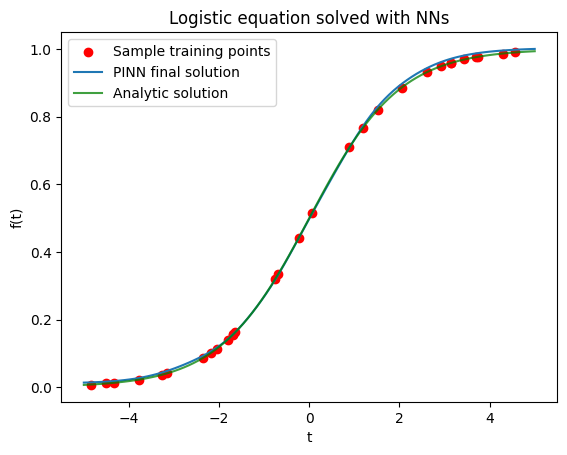

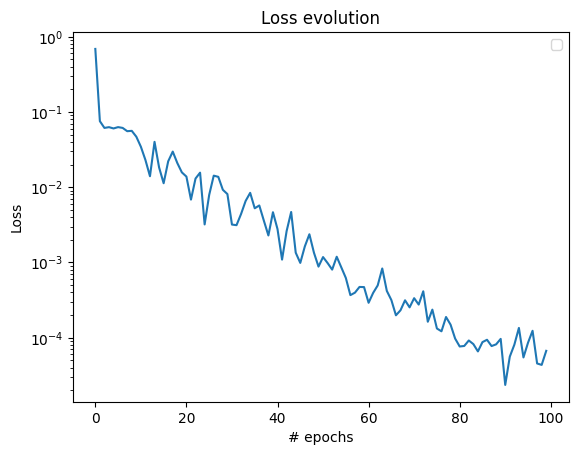

In [9]:
# Plotting the solution and loss evolution
x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)
f_eval = f(x_eval, params)
analytical_sol_fn = lambda x: 1.0 / (1.0 + (1.0/F_BOUNDARY - 1.0) * np.exp(-R * x))
x_eval_np = x_eval.detach().numpy()
x_sample_np = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1]).detach().numpy()

fig, ax = plt.subplots()
ax.scatter(x_sample_np, analytical_sol_fn(x_sample_np), color="red", label="Sample training points")
ax.plot(x_eval_np, f_eval.detach().numpy(), label="PINN final solution")
ax.plot(x_eval_np, analytical_sol_fn(x_eval_np), label="Analytic solution", color="green", alpha=0.75)
ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
ax.legend()

fig, ax = plt.subplots()
ax.semilogy(loss_evolution)
ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")
ax.legend()

plt.show()


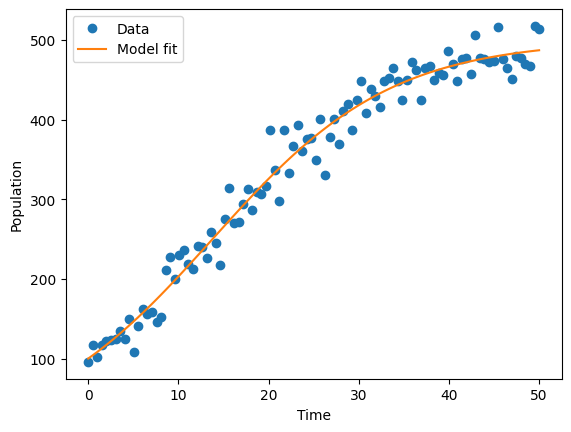

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Step 1: Generate synthetic data
def logistic_growth(u, t, r, K):
    return r * u * (1 - u / K)

# True parameters
r_true = 0.1
K_true = 500
u0 = 100

# Generate data
t = np.linspace(0, 50, 100)
u_true = odeint(logistic_growth, u0, t, args=(r_true, K_true)).flatten()
u_data = u_true + np.random.normal(0, 20, u_true.shape)  # adding some noise

# Step 2 & 3: Define the problem and implement data-driven discovery
def loss(params):
    r, K = params
    u_model = odeint(logistic_growth, u0, t, args=(r, K)).flatten()
    return np.mean((u_data - u_model)**2)

# Initial guess
params_initial = [0.05, 100]

# Optimize parameters
opt_result = minimize(loss, params_initial, method='Nelder-Mead')
r_est, K_est = opt_result.x

# Plot results
plt.plot(t, u_data, 'o', label='Data')
plt.plot(t, odeint(logistic_growth, u0, t, args=(r_est, K_est)), '-', label='Model fit')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()


In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd

def load_and_preprocess_data(filepath, test_size=0.2, random_state=42):
    try:
        df = pd.read_csv(filepath)
    except Exception as e:
        print(f"Error reading data file: {e}")
        return None, None, None, None

    y = df['output_val']
    X = df.drop(['output_val'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False, random_state=random_state)
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    return X_train, X_test, y_train, y_test
data_file_path = './train_data_histogram_longtime_210000_coursegrained.csv'
X_train, X_test, y_train, y_test = load_and_preprocess_data(data_file_path)

X_train shape: (1679200, 2)
y_train shape: (1679200,)


In [5]:
R_data = X_train['R'].values
U_data = X_train['U'].values 

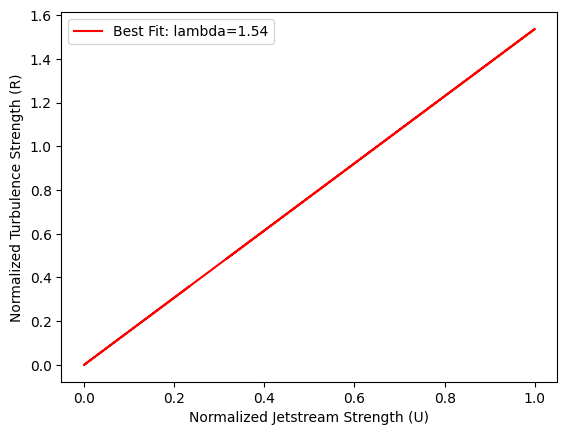

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Normalize the data
U_normalized = (U_data - np.min(U_data)) / (np.max(U_data) - np.min(U_data))
R_normalized = (R_data - np.min(R_data)) / (np.max(R_data) - np.min(R_data))

# Define the loss function for normalized data
def loss(lambda_val):
    R_pred = lambda_val * U_normalized
    return np.mean((R_normalized - R_pred)**2)

# Optimize lambda
initial_lambda = 0.1  # initial guess
opt_result = minimize(loss, initial_lambda, method='Nelder-Mead')
lambda_opt = opt_result.x[0]

# Plotting the results for visualization
# plt.scatter(U_normalized, R_normalized, label='Normalized Data')
plt.plot(U_normalized, lambda_opt * U_normalized, color='red', label=f'Best Fit: lambda={lambda_opt:.2f}')
plt.xlabel('Normalized Jetstream Strength (U)')
plt.ylabel('Normalized Turbulence Strength (R)')
plt.legend()
plt.show()


In [61]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Assuming U_data and R_data are provided as numpy arrays
# t_data should be the corresponding time points
t_data = np.linspace(0, 210, len(U_smoothed))
r_m = 0.1

# Interpolate R(t) data for use in ODE
from scipy.interpolate import interp1d
R = interp1d(t_data, R_smoothed, kind='linear', fill_value="extrapolate")


In [62]:
# Define the ODE function
def jetstream_ode(U, t, lambda_param):
    return lambda_param * (R(t) - r_m * U)

# Define the loss function
def loss(lambda_param):
    U_model = odeint(jetstream_ode, U_smoothed[0], t_data, args=(lambda_param,)).flatten()
    return np.mean((U_smoothed - U_model)**2)

# Initial guess for lambda
lambda_initial = 1

# Optimize lambda
opt_result = minimize(loss, lambda_initial, method='BFGS')
lambda_optimized = opt_result.x[0]


In [65]:
print(f"Optimized lambda: {lambda_optimized:.2f}")
# Plot results
plt.plot(t_data, U_smoothed, 'o', label='Data')
plt.plot(t_data, odeint(jetstream_ode, U_smoothed[0], t_data, args=(lambda_optimized,)), '-', label='Model fit')
plt.xlabel('Time')
plt.ylabel('Jetstream Strength')
plt.legend()
plt.show()


Optimized lambda: 1.00


KeyboardInterrupt: 

## Smoothing and Differentiating

In [57]:
from scipy.signal import savgol_filter

# Parameters for Savitzky-Golay filter
window_size = 8500  # Choose an odd number
polynomial_order = 3

# Apply filter to smooth and differentiate
U_smoothed = savgol_filter(U_normalized, window_size, polynomial_order)
U_derivative_sg = savgol_filter(U_data, window_size, polynomial_order, deriv=1)

R_smoothed = savgol_filter(R_normalized, window_size, polynomial_order)


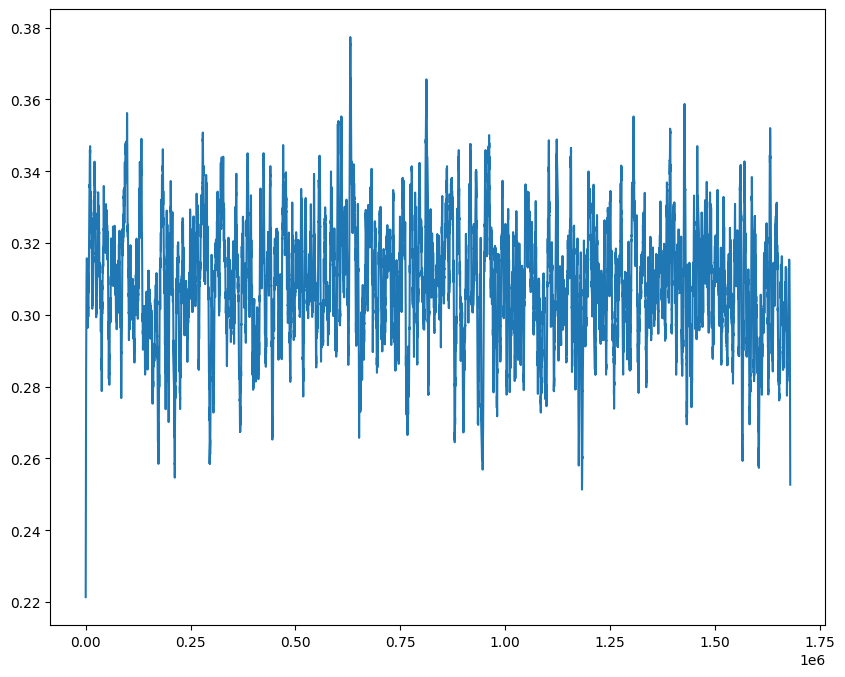

In [56]:
#set the figure size
plt.figure(figsize=(10,8))
plt.plot(U_smoothed)

In [45]:
# create a time array from U_data
t = np.linspace(0, 210000, len(U_data))

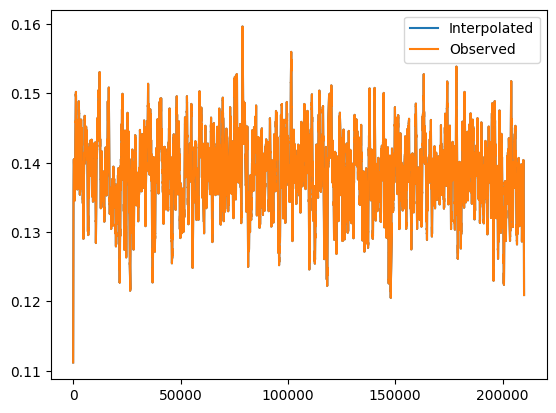

In [46]:
#interpolate the data
from scipy.interpolate import interp1d

# Interpolate the data
U_interpolated = interp1d(t, U_smoothed, kind='cubic')

# Plot the interpolated data
plt.plot(t, U_interpolated(t), label='Interpolated')
plt.plot(t, U_smoothed, label='Observed')
plt.legend()
plt.show()